# Compare models for visual proprioception

Compares regression models for visual proprioception, by running them on specific test data, and creating comparison graphs that put all of them onto the graphs. 

Each configuration is specified by a run of type visual_proprioception.

In [ ]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"


import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import math
import torch
import torch.nn as nn
#import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

#from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn, sp_vit

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training, load_multiview_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
experiment = "visual_proprioception"

# the lead run is the one that will provide the test data.
# also the directory of this run is where the graphs will be saved.

# all of them
# leadrun = "comp_all"
leadrun = "comp_vae"
# leadrun = "comp_resnet"
# leadrun = "comp_vgg"
# leadrun = "comp_all_with_vit"
# leadrun = "comp_vit"
# leadrun = "comp_aruco"
# leadrun = "comp_vit_multiview_base"
# leadrun = "comp_vit_multiview_large"
# leadrun = "comp_vit_multiview_all"


# now load them

leadexp = Config().get_experiment(experiment, leadrun)

runs = leadexp["tocompare"]

# runs = ["vp_convvae_128", "vp_convvae_256", "vp_ptun_vgg19_128", "vp_ptun_vgg19_256", "vp_ptun_resnet50_128", "vp_ptun_resnet50_256", "vp_aruco_128"]



exps = []
sps = [ ]
spexps = [ ]
models = [ ]
# FIXME: it is not a good idea to hardwire this, later we should refer
# from the comparison exprun
exp_robot = Config().get_experiment("robot_al5d", "position_controller_00")
for run in runs:
    exp = Config().get_experiment(experiment, run)
    exps.append(exp)
    spexp = Config().get_experiment(exp["sp_experiment"], exp["sp_run"])
    spexps.append(spexp)
    sp = get_visual_proprioception_sp(spexp, device)
    sps.append(sp)
    model = VisProprio_SimpleMLPRegression(exp)
    modelfile = pathlib.Path(exp["data_dir"],
                            exp["proprioception_mlp_model_file"])
    model.load_state_dict(torch.load(modelfile))
    model.to(device)
    models.append(model)


***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\comp_vae_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: visual_proprioception/comp_vae successfully loaded
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_convvae_128_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: visual_proprioception/vp_convvae_128 successfully loaded
***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/proprio_128 successfully loaded
***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/proprio_128 successfully loaded
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_convvae_256_s

C:\Users\lboloni\AppData\Local\Temp\ipykernel_66988\542956319.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelfile))


In [ ]:
# Load test data for the lead experiment
# task = leadexp["proprioception_testing_task"]
proprioception_input_file = pathlib.Path(
    leadexp.data_dir(), leadexp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    leadexp.data_dir(), leadexp["proprioception_test_target_file"])

# Check if lead experiment is multi-view
is_lead_multiview = leadexp.get("sensor_processing", "") == "Vit_multiview" or leadexp.get("num_views", 1) > 1

if is_lead_multiview:
    # Use multi-view loading function for the lead experiment
    tr = load_multiview_demonstrations_as_proprioception_training(
        task,
        proprioception_input_file,
        proprioception_target_file,
        num_views=leadexp.get("num_views", 2)
    )
else:
    # Use original single-view loading function
    # These are actually just using the last ones
    tr = load_demonstrations_as_proprioception_training(
        sps[0], leadexp, spexps[0], exp_robot, "validation_data", proprioception_input_file, proprioception_target_file, device=device
    )


# The targets should be the same regardless of single or multi-view
targets = tr["targets"]
print(f"There are {targets.shape[0]} target data points")

*** load_demonstrations_as_proprioception_training ***
	Successfully loaded from cached files c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\visual_proprioception\comp_vae\test_inputs.pt etc
There are 986 target data points


Iterate through all the components. The thing with it though is that this will get the test data from the components, not from the lead exp.

FIXME: maybe I could just write a function that runs a particular proprioceptor on a whole task and returns the y, and then just call that. 

In [5]:
no_from = 0
no_to = targets.shape[0]-1

ypreds = []

for exp, sp, spexp, model in zip(exps, sps, spexps, models):
    # Make sure both sp and model are on the same device
    model = model.to(device)
    proprioception_input_file = pathlib.Path(
        exp.data_dir(), exp["proprioception_test_input_file"])
    proprioception_target_file = pathlib.Path(
        exp.data_dir(), exp["proprioception_test_target_file"])

    # Check if this is a multi-view model
    is_multiview = exp.get("sensor_processing", "") == "Vit_multiview" or exp.get("num_views", 1) > 1

    if is_multiview:
        # Use the multi-view data loading function
        tr = load_multiview_demonstrations_as_proprioception_training(
            task,
            proprioception_input_file,
            proprioception_target_file,
            num_views=exp.get("num_views", 2)
        )

        # Process each data point
        ypred = []
        y = []
        t = []

        with torch.no_grad():
            for i in range(no_from, no_to):
                # Get the latent representation from sp (which handles the multi-view encoding)
                views = [view[i].unsqueeze(0).to(device) for view in tr["view_inputs"]]
                latent = sp.process(views)

                # Important: Make sure the latent tensor is on the same device as the model
                latent_tensor = torch.from_numpy(latent).unsqueeze(0).to(device)
                # Pass latent to regression model
                predictions = model(latent_tensor)
                # Append the data
                t.append(i)
                y.append(targets[i].numpy())
                ypred.append(predictions[0].cpu().numpy())
    else:
        # Original single-view approach
        tr = load_demonstrations_as_proprioception_training(
            sp, exp, spexp, "validation_data", proprioception_input_file, proprioception_target_file, device=device
        )        
        inputs = tr["inputs"]
        ypred = []
        y = []
        t = []
        with torch.no_grad():
            for i in range(no_from, no_to):
                # Move input to the correct device
                x = inputs[i].to(device)
                predictions = model(torch.unsqueeze(x, dim=0))

                # Move predictions back to CPU for numpy conversion
                # Append the data
                t.append(i)
                y.append(targets[i].numpy())
                ypred.append(predictions[0].cpu().numpy())

    ypred = np.array(ypred)
    ypreds.append(ypred)
    y = np.array(y)
    t = np.array(t)

*** load_demonstrations_as_proprioception_training ***
	Successfully loaded from cached files c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\visual_proprioception\vp_convvae_128\test_inputs.pt etc
*** load_demonstrations_as_proprioception_training ***
	Successfully loaded from cached files c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\visual_proprioception\vp_convvae_256\test_inputs.pt etc


## Time compare plot - double column
At this point, we should have the ypreds, the y and the t and we can plot them.

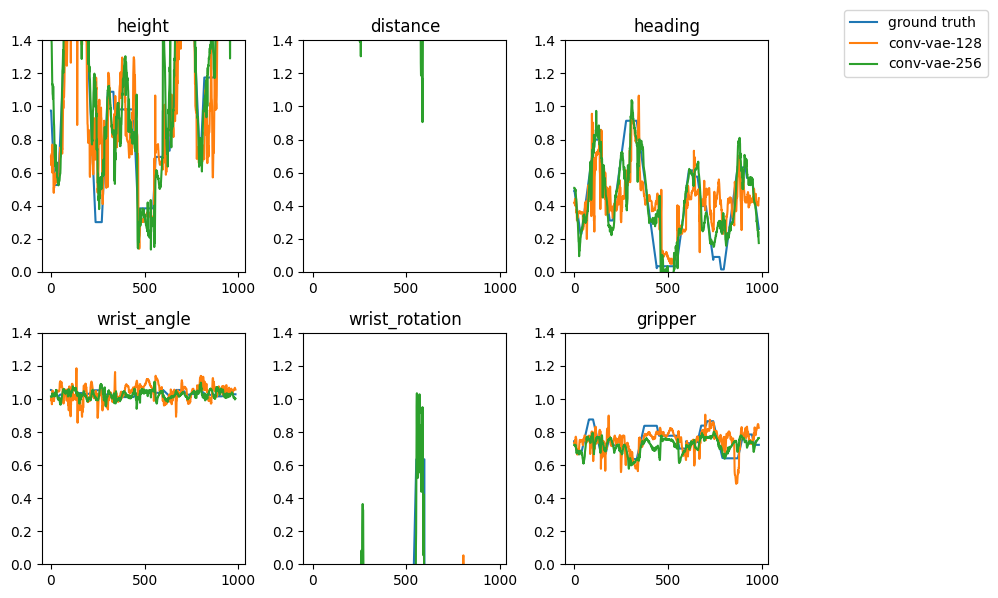

In [6]:
fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3]
    ax.set_ylim(0, 1.4)
    ax.plot(t, y[:,i], label="ground truth")
    for ypred, exp in zip(ypreds,exps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=exp["name"])
    if i==0:
        fig.legend(bbox_to_anchor=(1.25, 1))
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, single column

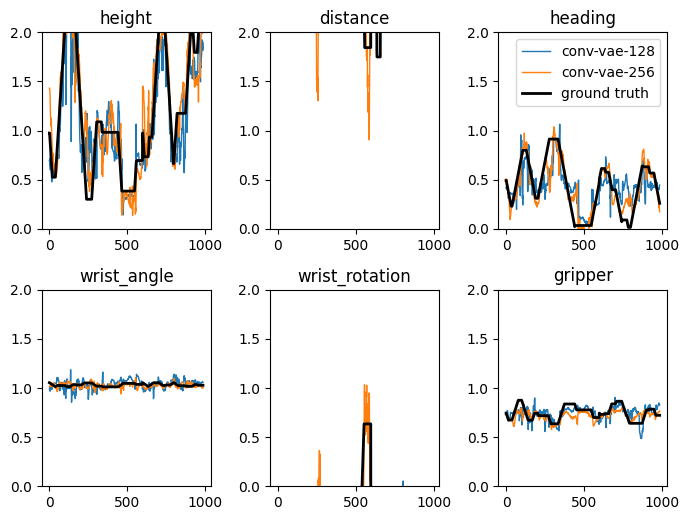

In [7]:
fig, axs = plt.subplots(2,3, figsize=(7, 5.3))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3]
    ax.set_ylim(0, 2.0)
    for ypred, exp in zip(ypreds,exps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
    ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
    if i==2:
        ax.legend()
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, vertical with legend bottom

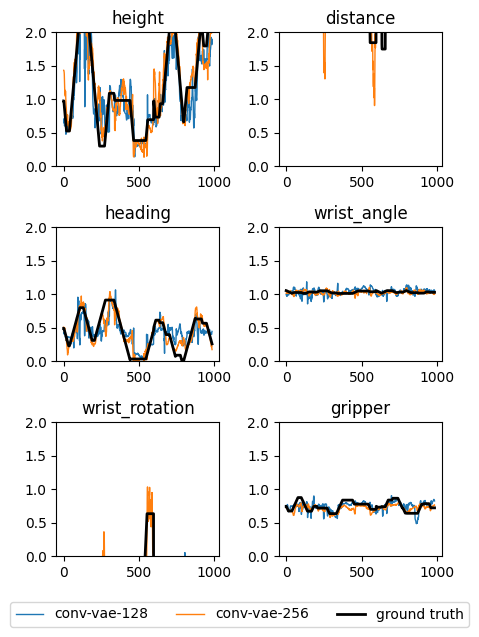

In [8]:
#fig, axs = plt.subplots(3,2, figsize=(5.3, 7))
fig, axs = plt.subplots(3,2, figsize=(4.6, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//2, i%2]
    ax.set_ylim(0, 2.0)
    for ypred, exp in zip(ypreds,exps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
    ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=len(exps)+1,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

### Comparing the average accuracy
Create a graph that is comparing the average accuracy. 

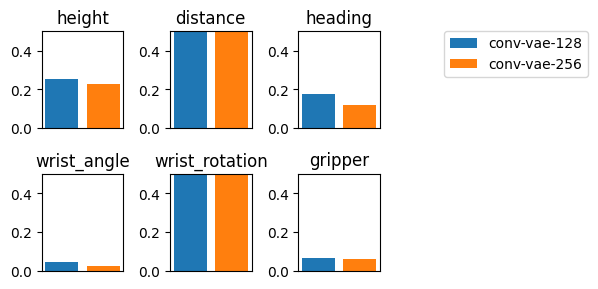

In [9]:
fig, axs = plt.subplots(2,3, figsize=(4, 3))

for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 0.4)
    ax.set_ylim(0, 0.5)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    for ypred, exp in zip(ypreds,exps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(exp["name"], error)
        bars.append(br)
        names.append(exp["name"])
    # Remove x-axis labels if desired
    ax.set_xticks([])
    if i==0:
        fig.legend(bars, names, bbox_to_anchor=(1.50, 0.9), ncol=1)
    fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

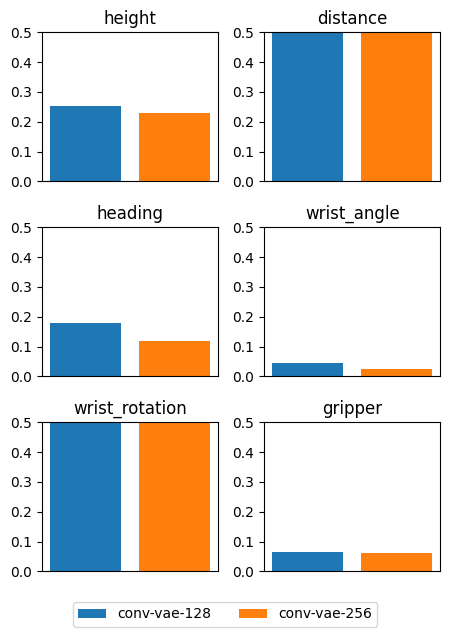

In [10]:
fig, axs = plt.subplots(3,2, figsize=(4.6, 6))

for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//2, i%2]
    # ax.set_ylim(0, 0.4)
    ax.set_ylim(0, 0.5)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    for ypred, exp in zip(ypreds,exps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(exp["name"], error, label=exp["name"])
        bars.append(br)
        names.append(exp["name"])
    # Remove x-axis labels if desired
    ax.set_xticks([])
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        #ncolumn = len(exps)
        ncolumn = 2
        fig.legend(handles, labels, ncol=ncolumn,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    # fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')